In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Load the original and bootstrapped datasets
df_original = pd.read_csv('alpha_combined_cleaned.csv')
df_bootstrapped = pd.read_csv('tuned1_alpha_thalassemia_gaussian_bootstrapped_dataset_200000.csv')

d:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:38:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Bootstrapped Dataset Model Performance
Accuracy: 0.60498

Classification Report:
                 precision    recall  f1-score   support

 alpha carrier       0.58      0.41      0.48     12500
   alpha trait       0.56      0.60      0.58      7500
        normal       0.67      0.88      0.76     20000
silent carrier       0.45      0.29      0.35     10000

      accuracy                           0.60     50000
     macro avg       0.56      0.55      0.54     50000
  weighted avg       0.58      0.60      0.58     50000



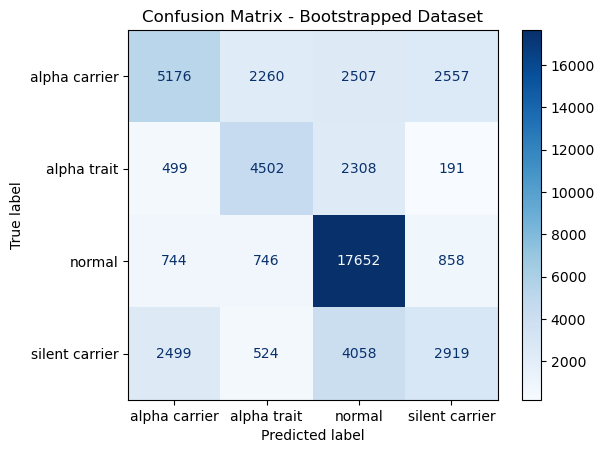

In [4]:
# Encode bootstrapped dataset
label_encoder_boot = LabelEncoder()
df_bootstrapped['phenotype_encoded'] = label_encoder_boot.fit_transform(df_bootstrapped['phenotype'])

# Encode categorical features in bootstrapped dataset
sex_encoder_boot = LabelEncoder()
df_bootstrapped['sex_encoded'] = sex_encoder_boot.fit_transform(df_bootstrapped['sex'])

# Feature Engineering: Derived Features
df_bootstrapped['mcv_rbc_ratio'] = df_bootstrapped['mcv'] / df_bootstrapped['rbc']
df_bootstrapped['mch_rbc_ratio'] = df_bootstrapped['mch'] / df_bootstrapped['rbc']
df_bootstrapped['hb_mcv_ratio'] = df_bootstrapped['hb'] / df_bootstrapped['mcv']

# Optional: Polynomial Features (you can add if needed)
# df_bootstrapped['mcv_squared'] = df_bootstrapped['mcv'] ** 2
# df_bootstrapped['mch_squared'] = df_bootstrapped['mch'] ** 2

# Prepare features and labels
X_boot = df_bootstrapped[['hb', 'rbc', 'mcv', 'mch', 'hba2', 'sex_encoded',
                          'mcv_rbc_ratio', 'mch_rbc_ratio', 'hb_mcv_ratio']]
y_boot = df_bootstrapped['phenotype_encoded']

# Train-test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_boot, y_boot, stratify=y_boot, test_size=0.25, random_state=42)

# Build model
model_boot = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model_boot.fit(X_train_b, y_train_b)

# Evaluate model
y_pred_b = model_boot.predict(X_test_b)
print("\nBootstrapped Dataset Model Performance")
print("Accuracy:", accuracy_score(y_test_b, y_pred_b))
print("\nClassification Report:\n", classification_report(y_test_b, y_pred_b, target_names=label_encoder_boot.classes_))

# Plot confusion matrix
cm_b = confusion_matrix(y_test_b, y_pred_b)
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=label_encoder_boot.classes_)
disp_b.plot(cmap='Blues')
plt.title('Confusion Matrix - Bootstrapped Dataset')
plt.show()

d:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:39:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



SMOTE-Augmented Model Performance
Accuracy: 0.55456

Classification Report:
                 precision    recall  f1-score   support

 alpha carrier       0.61      0.33      0.43     12500
   alpha trait       0.45      0.85      0.59      7500
        normal       0.74      0.61      0.67     20000
silent carrier       0.39      0.50      0.44     10000

      accuracy                           0.55     50000
     macro avg       0.55      0.57      0.53     50000
  weighted avg       0.60      0.55      0.55     50000



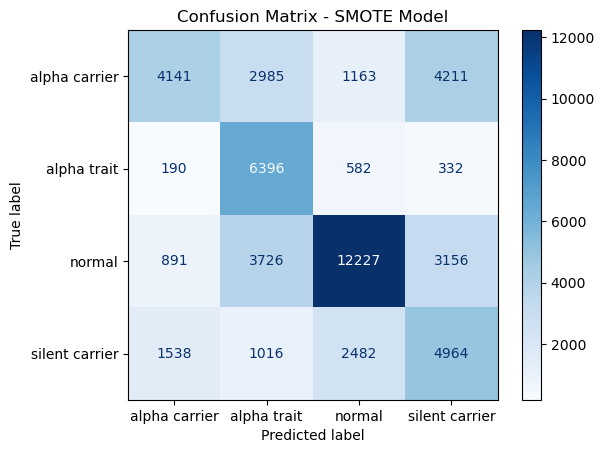

In [7]:

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_b_imputed = imputer.fit_transform(X_train_b)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_b_imputed, y_train_b)

# Build model with SMOTE data
model_smote = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# Evaluate model
y_pred_smote = model_smote.predict(X_test_b)
print("\nSMOTE-Augmented Model Performance")
print("Accuracy:", accuracy_score(y_test_b, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test_b, y_pred_smote, target_names=label_encoder_boot.classes_))

# Plot confusion matrix
cm_smote = confusion_matrix(y_test_b, y_pred_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=label_encoder_boot.classes_)
disp_smote.plot(cmap='Blues')
plt.title('Confusion Matrix - SMOTE Model')
plt.show()

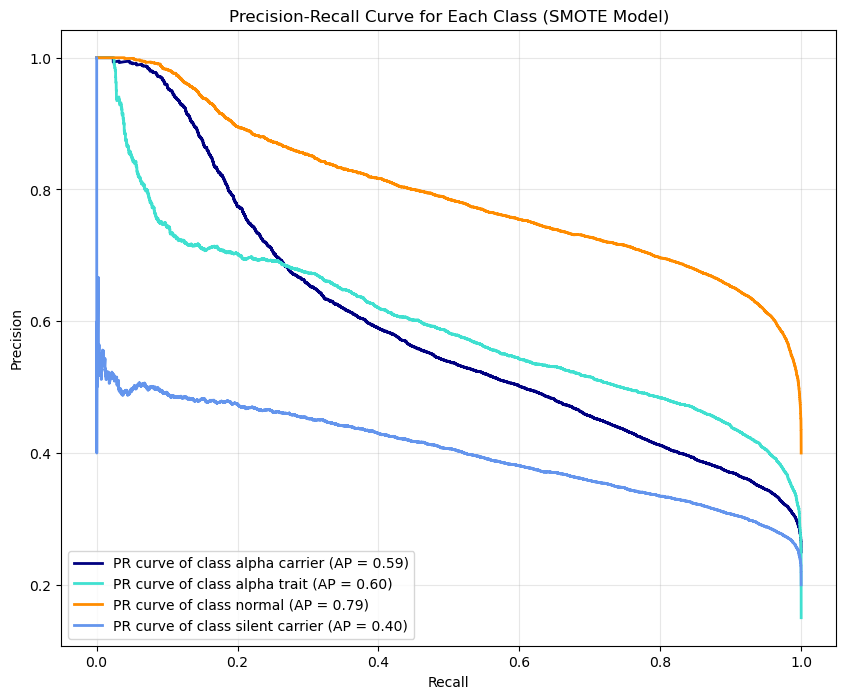

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay

import matplotlib.pyplot as plt
import numpy as np

# Binarize the output labels for multi-class PR curve
y_test_binarized = label_binarize(y_test_b, classes=[0, 1, 2, 3])
n_classes = y_test_binarized.shape[1]

# Get prediction probabilities
y_score = model_smote.predict_proba(X_test_b)

# Compute Precision-Recall and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue']

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='PR curve of class {0} (AP = {1:0.2f})'
                   ''.format(label_encoder_boot.classes_[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class (SMOTE Model)')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()
